# $제 1고지$

## Step1. 상자로서의 변수

### Variable 클래스 구현

In [ ]:
class Variable:
    def __init__(self,data):
        self.data = data

In [ ]:
import numpy as np

data = np.array(1.0)
x = Variable(data)
print (x.data)

In [ ]:
x.data = np.array(2.0)
print (x.data)

## Step2. 변수를 낳는 함수

### Function 클래스 구현

In [ ]:
class Function:
    def __call__(self, input):
        x = input.data # 데이터를 꺼낸디
        y = x**2 # 실제 계산
        output = Variable(y) # Variable 형대로 되돌린다.
        return output

### Function 클래스 이용

In [ ]:
x = Variable(np.array(10))
f = Function()
y = f(x)

print (type(y))
print (y.data)

In [ ]:
# Function 클래스 수정
class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        return output
    
    def forward(self, x):
        raise NotImplementedError()

In [ ]:
# Function 클래스를 상속받음
class Square(Function):
    def forward(self, x):
        return x**2

In [ ]:
x = Variable(np.array(10))
f = Square()
y = f(x)

print (type(y))
print (y.data)

## Step3. 함수연결

### Exp 함수 구현

In [ ]:
class Exp(Funtion):
    def forward(self, x):
        return np.exp(x)

## 함수 연결

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

print(y.data)

## Step4. 수치 미분

### 수치 미분 구현

In [ ]:
def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data) / (2*eps)

In [ ]:
f = Square()
x = Variable(np.array(2.0))
dy = numerical_diff(f, x)
print (dy)

### 합성 함수의 미분

In [ ]:
def f(x):
    A = Square()
    B = Exp()
    C = Square()
    return C(B(A(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x)
print (dy)

## Step6. 수동 역전파

### Variable 클래스 추가 구현

In [ ]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None

### Function 클래스 추가 구현

In [ ]:
class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        self.input = input # 입력 변수를 기억(보관)한다.
        return output
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

### Square와 Exp 클래스 추가 구현

In [ ]:
class Square(Function):
    def forward(self, x):
        y = x**2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2*x*gy
        return gx

In [ ]:
class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

### 역전파 구현

In [ ]:
import numpy as np

A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

In [ ]:
y.grad = np.array(1.0)
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
print(x.grad)

## Step7. 역전파 자동화

### 역전파 자동화의 시작

In [ ]:
import numpy as np

In [ ]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func

In [ ]:
class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(y)
        output.set_creator(self) # 출력 변수에 창조자를 설정한다.
        self.input = input
        self.output = output # 출력도 저장한다.
        return output

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# 계산 그래프의 노드들을 거꾸로 거슬러 올라간다.
assert y.creator == C
assert y.creator.input == b
assert y.creator.input.creator == B
assert y.creator.input.creator.input == a
assert y.creator.input.creator.input.creator == A
assert y.creator.input.creator.input.creator.input == x

### 역전파 도전

In [ ]:
y.grad = np.array(1.0)

C = y.creator # 1. 함수를 가져온다.
b = C.input # 2. 함수의 입력을 가져온다.
b.grad = C.backward(y.grad) # 3. 함수의 backward 메서드를 호출한다.

In [ ]:
B = b.creator # 1. 함수를 가져온다.
a = B.input # 2. 함수의 입력을 가져온다.
a.grad = B.backward(b.grad) # 3. 함수의 backward 메서드를 호출한다.

In [ ]:
A = a.creator # 1. 함수를 가져온다.
x = A.input # 2. 함수의 입력을 가져온다.
x.grad = A.backward(a.grad) # 3. 함수의 backward 메서드를 호출한다.

print (x.grad)

### backward 메서드 추가

In [ ]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        f = self.creator # 1. 함수를 가져온다.
        if f is not None:
            x = f.input # 2. 함수의 입력을 가져온다.
            x.grad = f.backward(self.grad) # 3. 함수의 backward 메서드를 호출한다.
            x.backward() # 하나 앞 변수의 backward 메서드를 호출한다(재귀).

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# 역전파
y.grad = np.array(1.0)
y.backward()
print (x.grad)

## Step8. 재귀에서 반복문으로

### 현재의 Variable 클래스

In [ ]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        f = self.creator
        if f is not None:
            x = f.input
            x.grad = f.backward(self.grad)
            x.backward()

### 반복문을 이용한 구현

In [ ]:
import numpy as np


class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            x, y = f.input, f.output # 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

### 동작 확인

In [ ]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# 역전파
y.grad = np.array(1.0)
y.backward()
print (x.grad)

## Step9. 함수를 더 편리하게

### 파이썬 함수로 이용하기

In [ ]:
x = Variable(np.array(0.5))
f = Square()
y = f(x)

In [ ]:
def square(x):
    f = Square()
    return f(x)

def exp(x):
    f = Exp()
    return f(x)

In [ ]:
# 위 코드를 한 줄로 표현
def square(x):
    return Square()(x)

def exp(x):
    return Exp()(x)

In [ ]:
x = Variable(np.array(0.5))
a = square(x)
b = exp(a)
y = square(b)

y.grad = np.array(1.0)
y.backward()
print (x.grad)

In [ ]:
# 함수를 연속으로 적용
x = Variable(np.array(0.5))
y = square(exp(square(x)))
y.grad = np.array(1.0)
y.backward()
print (x.grad)

### backward 메서드 간소화

In [ ]:
# y.grad = np.array(1.0) 생략하기

class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None: # grad가 None이면 자동으로 미분값을 생성
            self.grad = np.ones_like(self.data)
            
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            x, y = f.input, f.output # 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

In [ ]:
x = Variable(np.array(0.5))
y = square(exp(square(x)))
y.backward()
print (x.grad)

### ndarray만 취급하기

In [ ]:
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
                
        self.data = data
        self.grad = None
        self.creator = None

In [ ]:
x = Variable(np.array(1.0))
x = Variable(None)

x = Variable(1.0)

In [ ]:
x = np.array([1.0])
y = x**2
print (type(x), x.ndim)
print (type(y))

In [ ]:
x = np.array(1.0)
y = x**2
print (type(x), x.ndim)
print (type(y))

In [ ]:
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [ ]:
np.isscalar(np.float64(1.0))

In [ ]:
np.isscalar(2.0)

In [ ]:
np.isscalar(np.array(1.0))

In [ ]:
np.isscalar(np.array([1, 2, 3]))

In [ ]:
class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(as_array(y))
        output.set_creator(self)
        self.input = input
        self.output = output
        return output

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

## Step10. 테스트

### 파이썬 단위 테스트

In [ ]:
import unittest

class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)

In [ ]:
unittest.main()

### square 함수의 역전파 테스트

In [ ]:
class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)
    
    def test_backward(self):
        x = Variable(np.array(3.0))
        y = square(x)
        y.backward()
        expected = np.array(6.0)
        self.assertEqual(x.grad, expected)

### 기울기 확인을 이용한 자동 테스트

In [ ]:
def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y2.data)/(2*eps)

class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)
    
    def test_backward(self):
        x = Variable(np.array(3.0))
        y = square(x)
        y.backward()
        expected = np.array(6.0)
        self.assertEqual(x.grad, expected)
        
    def test_gradient_check(self):
        x = Variable(np.random.rand(1)) # 무작위 입력값 생성
        y = square(x)
        y.backward()
        num_grad = numerical_diff(square, x)
        flg = np.allclose(x.grad, num_grad)
        self.assertTrue(flg)

# $제 2고지$

## Step11. 가변 길이 인수(순전파 편)

### Function 클래스 수정

In [ ]:
import numpy as np
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            x, y = f.input, f.output
            x.grad = f.backward(y.grad)

            if x.creator is not None:
                funcs.append(x.creator)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


In [ ]:
class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(as_array(y))
        output.set_creator(self)
        self.input = input
        self.output = output
        return output

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

In [ ]:
class Function:
    def __call__(self, inputs):
        xs = [x.data for x in inputs]  # Get data from Variable
        ys = self.forward(xs)
        outputs = [Variable(as_array(y)) for y in ys]  # Wrap data

        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

### Add 클래스 구현

In [ ]:
class Add(Function):
    def forward(self, xs):
        x0, x1 = xs
        y = x0 + x1
        return (y,)

In [ ]:
xs = [Variable(np.array(2)), Variable(np.array(3))]
f = Add()
ys = f(xs)
y = ys[0]
print(y.data)

## Step12. 가변 길이 인수(개선 편)

### 첫 번째 개선: 함수를 사용하기 쉽게

In [ ]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(xs)
        outputs = [Variable(as_array(y)) for y in ys]
        
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        
        return outputs if len(outputs) > 1 else outputs[0]

In [ ]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
f = Add()
y = f(x0, x1)
print (y.data)

### 두 번째 개선: 함수를 구현하기 쉽도록

In [ ]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys, )
        outputs = [Variable(as_array(y)) for y in ys]
        
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        
        return outputs if len(outputs) > 1 else outputs[0]

In [ ]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

### add 함수 구현

In [ ]:
def add(x0, x1):
    return Add()(x0, x1)

In [ ]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
y = add(x0, x1) # Add 클래스 생성 과정이 감춰짐
print (y.data)

## Step13. 가변 길이 인수(역전파 편)

### 가변 길이 인수에 대응한 Add 클래스의 역전파

In [ ]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    
    def backward(self, gy):
        return gy, gy

### Variable 클래스 수정

In [ ]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self. data)
            
        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            x, y = f.input, f.output # 함수의 입출력을 얻는다
            x.grad = f.backward(y.grad) # backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator)

In [ ]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
            
        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
                
            for x, gx in zip(f.inputs, gxs):
                x.grad = gx
                
                if x.creator is not None:
                    funcs.append(x.creator)

### Square 클래스 구현

In [ ]:
class Square(Function):
    def forward(self, x):
        y = x**2
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data # 수정 전: x = self.input.data
        gx = 2 * x * gy
        return gx

In [ ]:
def square(x):
    f = Square()
    return f(x)

In [ ]:
x = Variable(np.array(2.0))
y = Variable(np.array(3.0))

z = add(square(x), square(y))
z.backward()
print (z.data)
print (x.grad)
print (y.grad)

## Step14. 같은 변수 반복 사용

### 문제의 원인

In [ ]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
            
        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
                
            for x, gx in zip(f.inputs, gxs):
                x.grad = gx # 여기가 실수!
                
                if x.creator is not None:
                    funcs.append(x.creator)

In [ ]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
            
        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
                
            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
                
                if x.creator is not None:
                    funcs.append(x.creator)

In [ ]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print (x.grad)

In [ ]:
x = Variable(np.array(3.0))
y = add(add(x, x),x)
y.backward()
print (x.grad)

### 미분값 재설정

In [ ]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
            
        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
                
            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
                
                if x.creator is not None:
                    funcs.append(x.creator)
                    
    def cleargrad(self):
        self.grad = None

In [ ]:
# 첫 번째 계산
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print (x.grad)

# 두 번째 계산(같은 x를 사용하여 다른 계산을 수행)
x.cleargrad()
y = add(add(x, x),x)
y.backward()
print (x.grad)

## Step15. 복잡한 계산 그래프(이론 편)

file:///home/aiffel/Downloads/%EB%B0%91%EB%B0%94%EB%8B%A53%20%EA%B7%B8%EB%A6%BC%EA%B3%BC%20%EC%88%98%EC%8B%9D/%EA%B7%B8%EB%A6%BC%2015-8.png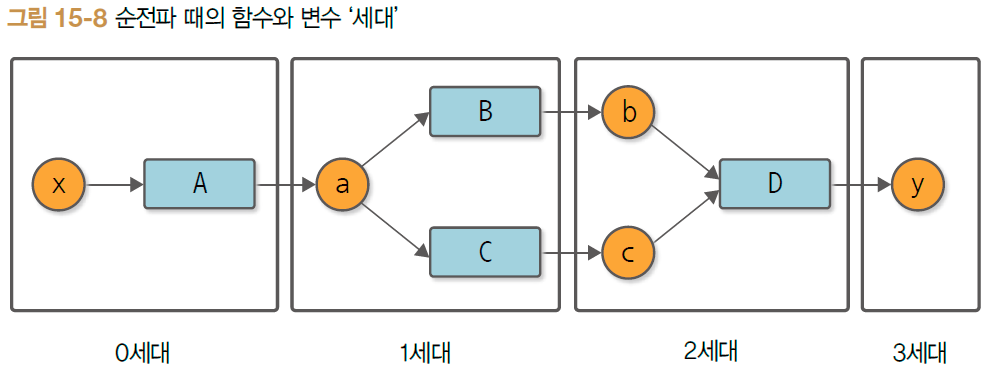

## Step16. 복잡한 계산 그래프(구현 편)

### 세대 추가

In [ ]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
                
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다(부모 세대 +1).
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
            
        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
                
            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
                
                if x.creator is not None:
                    funcs.append(x.creator)
                    
    def cleargrad(self):
        self.grad = None

In [ ]:
class Function(object):
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys, )
        outputs = [Variable(as_array(y)) for y in ys]
        
        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


### 세대 순으로 꺼내기

In [ ]:
generations = [2, 0, 1, 4, 2]
funcs = []

for g in generations:
    f = Function() # 더미 함수 클래스
    f.generation = g
    funcs.append(f)
    
[f.generation for f in funcs]

In [ ]:
funcs.sort(key = lambda x: x.generation) # 리스트 정렬
[f.generation for f in funcs]

In [ ]:
f = funcs.pop()
f.generation

### Variable 클래스의 backward

In [ ]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
                
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다(부모 세대 +1).
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
            
        funcs = []
        seen_set = set()
        
        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
                
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop()
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
                
            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
                    
                if x.creator is not None:
                    add_func(x.creator) # 수정 전: funcs.append(x.creator)

### 동작 확인

In [ ]:
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = 2 * x * gy
        return gx


def square(x):
    return Square()(x)

In [ ]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    return Add()(x0, x1)

In [ ]:
x = Variable(np.array(2.0))
a = square(x)
y = add(square(a), square(a))
y.backward()

print (y.data)
print (x.grad)

## Step17. 메모리 관리와 순환 참조

### weakref 모듈

In [ ]:
import weakref
import numpy as np

a = np.array([1,2,3])
b = weakref.ref(a)

b

In [ ]:
a = None
b

In [ ]:
class Function(object):
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys, )
        outputs = [Variable(as_array(y)) for y in ys]
        
        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs]
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

In [ ]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
                
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다(부모 세대 +1).
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
            
        funcs = []
        seen_set = set()
        
        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
                
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop()
            # 수정 전: gys = [output.grad for output in f.outputs] 
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs, )
                
            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
                    
                if x.creator is not None:
                    add_func(x.creator)

### 동작 확인

In [ ]:
for i in range(10):
    x = Variable(np.random.randn(10000)) # 거대한 데이터
    y = square(square(square(x)))

## Step18. 메모리 절약 모드

### 필요 없는 미분값 삭제

In [ ]:
import numpy as np

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref

In [ ]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()
print(y.grad, t.grad)  # None None
print(x0.grad, x1.grad)  # 2.0 1.0

### Function 클래스 복습

In [ ]:
class Function(object):
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys, )
        outputs = [Variable(as_array(y)) for y in ys]
        
        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs]
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

### Config 클래스를 활용한 모드 전환

In [ ]:
class Config:
    enable_backprop = True

In [ ]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs]) # 세대 설정
            for output in outputs:
                output.set_creator(self) # 연결 설정
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

### 모드 전환

In [ ]:
Config.enable_backprop = True
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))
y.backward()

Config.enable_backprop = False
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))

### with 문을 활용한 모드 전환

In [ ]:
import contextlib

@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)

In [ ]:
with using_config('enable_backprop', False):
    x = Variable(np.array(2.0))
    y = square(x)

In [ ]:
def no_grad():
    return using_config('enable_backprop', False)

with no_grad():
    x = Variable(np.array(2.0))
    y = square(x)

## Step19. 변수 사용성 개선

### 변수 이름 지정

In [ ]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
                
        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref

### ndarray 인스턴스 변수

In [ ]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
                
        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
    
    @property
    def shape(self):
        return self.data.shape

In [ ]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
print (x.shape)

In [ ]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
                
        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def ndim(self):
        return self.data.ndim
    
    @property
    def size(self):
        return self.data.size
    
    @property
    def dtype(self):
        return self.data.dtype

### len 함수와 print 함수

In [ ]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))
                
        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def ndim(self):
        return self.data.ndim
    
    @property
    def size(self):
        return self.data.size
    
    @property
    def dtype(self):
        return self.data.dtype
    
    def __len__(self):
        return len(self.data)

In [ ]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
print (len(x))

In [ ]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref

## Step20. 연산자 오버로드(1)

### Mul 클래스 구현

In [ ]:
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [ ]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [ ]:
Variable.__add__ = add
Variable.__mul__ = mul

In [ ]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

In [ ]:
class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0

In [ ]:
def mul(x0, x1):
    return Mul()(x0, x1)

In [ ]:
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

y = add(mul(a, b), c)
# y = a * b + c
y.backward()

print(y)
print(a.grad)
print(b.grad)

In [ ]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'
    
    def __mul__(self, other):
        return mul(self, other)
    
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [ ]:
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
y = a * b
print (y)

In [ ]:
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

# y = add(mul(a, b), c)
y = a * b + c
y.backward()

print(y)
print(a.grad)
print(b.grad)

## Step21. 연산자 오버로드(2)

### ndarray와 함께 사용하기

In [ ]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [ ]:
def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)

In [ ]:
class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

In [ ]:
x = Variable(np.array(2.0))
y = x + np.array(3.0)
print(y)

### float, int와 함께 사용하기

In [ ]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)

In [ ]:
x = Variable(np.array(2.0))
y = x + 3.0
print(y)

### 문제점 1 : 첫 번째 인수가 float나 int인 경우

In [ ]:
class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)

In [ ]:
Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul

In [ ]:
x = Variable(np.array(2.0))
y = 3.0 * x + 1.0
print(y)

### 문제점 2: 좌항이 ndarray 인스턴스인 경우

In [ ]:
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [ ]:
x = Variable(np.array([1.0]))
y = np.array([2.0]) + x
print(y)

## Step22. 연산자 오버로드(3)

### 음수(부호 변환)

In [ ]:
class Neg(Function):
    def forward(self, x):
        return -x
    
    def backward(self, gy):
        return -gy
    
def neg(x):
    return Neg()(x)
    
Variable.__neg__ = neg

In [ ]:
x = Variable(np.array(2.0))
y = -x # 부호를 바꾼다.
print (y)

### 뺄셈

In [ ]:
class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y
    
    def backward(self, gy):
        return gy, -gy
    
def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)

Variable.__sub__ = sub

In [ ]:
def rsub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x1, x0) # x0와 x1의 순서를 바꾼다.

Variable.__rsub__ = rsub

In [ ]:
x = Variable(np.array(2.0))
y1 = 2.0 - x
y2 = x - 1.0
print (y1)
print (y2)

### 나눗셈

In [ ]:
class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1

def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)

def rdiv(x0, x1):
    x1 = as_array(x1)
    return Div()(x1, x0) # x0과 x1의 순서를 바꾼다.

Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv

### 거듭제곱

In [ ]:
class Pow(Function):
    def __init__(self, c):
        self.c = c
        
    def forward(self, x):
        y = x ** self.c
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c
        gx = c * x ** (c-1) * gy
        return gx
    
def pow(x, c):
    return Pow(c)(x)

Variable.__pow__ = pow

In [ ]:
x = Variable(np.array(2.0))
y = x ** 3
print (y)

## Step24 복잡한 함수의 미분

### Sphere 함수

In [ ]:
import numpy as np
from core_simple import Variable

def sphere(x, y):
    z = x ** 2 + y ** 2
    return z



In [ ]:
x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = sphere(x, y)
z.backward()
print(x.grad, y.grad)

### matyas 함수

In [ ]:
def matyas(x, y):
    z = 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y
    return z

In [ ]:
x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = matyas(x, y)
z.backward()
print(x.grad, y.grad)

### Goldstein-Price 함수

In [ ]:
def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z

In [ ]:
x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)  # sphere(x, y) / matyas(x, y)
z.backward()
print(x.grad, y.grad)

## Step25. 계산 그래프 시각화(1)

In [ ]:
from core_simple import Variable

### DOT 언어로 그래프 작성하기

In [ ]:
digraph g{
x
y
}

### 노드에 속성 지정하기

digraph g {
1 [label="x", color=orange, style=filled]
2 [label="y", color=orange, style=filled]
3 [label="Exp", color=lightblue, style=filled, shape=box]
1 -> 3
3 -> 2
}

## Step26. 계산 그래프 시각화(2)

In [ ]:
import numpy as np
from core_simple import Variable
from utils import get_dot_graph

In [ ]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

txt = get_dot_graph(y, verbose=False)
print(txt)

with open('sample.dot', 'w') as o:
    o.write(txt)

### 계산 그래프에서 DOT 언어로 변환하기

In [ ]:
def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=filled]\n'

    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ': '
        name += str(v.shape) + ' ' + str(v.dtype)

    return dot_var.format(id(v), name)

In [ ]:
def _dot_func(f):
    # for function
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    ret = dot_func.format(id(f), f.__class__.__name__)

    # for edge
    dot_edge = '{} -> {}\n'
    for x in f.inputs:
        ret += dot_edge.format(id(x), id(f))
    for y in f.outputs:  # y is weakref
        ret += dot_edge.format(id(f), id(y()))
    return ret

In [ ]:
def get_dot_graph(output, verbose=True):
    """Generates a graphviz DOT text of a computational graph.
    Build a graph of functions and variables backward-reachable from the
    output. To visualize a graphviz DOT text, you need the dot binary from the
    graphviz package (www.graphviz.org).
    Args:
        output (dezero.Variable): Output variable from which the graph is
            constructed.
        verbose (bool): If True the dot graph contains additional information
            such as shapes and dtypes.
    Returns:
        str: A graphviz DOT text consisting of nodes and edges that are
            backward-reachable from the output
    """
    txt = ''
    funcs = []
    seen_set = set()

    def add_func(f):
        if f not in seen_set:
            funcs.append(f)
            # funcs.sort(key=lambda x: x.generation)
            seen_set.add(f)

    add_func(output.creator)
    txt += _dot_var(output, verbose)

    while funcs:
        func = funcs.pop()
        txt += _dot_func(func)
        for x in func.inputs:
            txt += _dot_var(x, verbose)

            if x.creator is not None:
                add_func(x.creator)

    return 'digraph g {\n' + txt + '}'

### 이미지 변환까지 한 번에

In [ ]:
def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose)

    # 1. dot 데이터를 파일에 저장
    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')
    if not os.path.exists(tmp_dir):
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')

    with open(graph_path, 'w') as f:
        f.write(dot_graph)

    # 2. dot 명령 호출    
    extension = os.path.splitext(to_file)[1][1:]  # Extension(e.g. png, pdf)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True)

### 동작 확인

In [ ]:
import numpy as np
from core_simple import Variable
from utils import plot_dot_graph

In [ ]:
def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z


x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png')

## Step27. 테일러 급수 미분

### sin 함수 구현

In [ ]:
import numpy as np
from core_simple import Function

class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx


def sin(x):
    return Sin()(x)

In [ ]:
from core_simple import Variable

x = Variable(np.array(np.pi / 4))
y = sin(x)
y.backward()
print('--- original sin ---')
print(y.data)
print(x.grad)

### 테일러 급수 이론

### 테일러 급수 구현

In [1]:
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


In [ ]:
import math

def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):
        c = (-1)**i/math.factorial(2*i+1)
        t = c*x**(2*i+1)
        y = y+t
        if abs(t.data)<threshold:
            break
    return y

In [ ]:
#from core_simple import Variable

x = Variable(np.array(np.pi / 4))
y = my_sin(x)  # , threshold=1e-150)
y.backward()
print('--- approximate sin ---')
print(y.data)
print(x.grad)

## Step28. 함수 최적화

### 로젠브록 함수

file:///home/aiffel/Downloads/%EB%B0%91%EB%B0%94%EB%8B%A53%20%EA%B7%B8%EB%A6%BC%EA%B3%BC%20%EC%88%98%EC%8B%9D/%EC%8B%9D%2028.1.png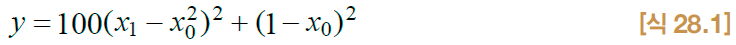

file:///home/aiffel/Downloads/%EB%B0%91%EB%B0%94%EB%8B%A53%20%EA%B7%B8%EB%A6%BC%EA%B3%BC%20%EC%88%98%EC%8B%9D/%EA%B7%B8%EB%A6%BC%2028-1.png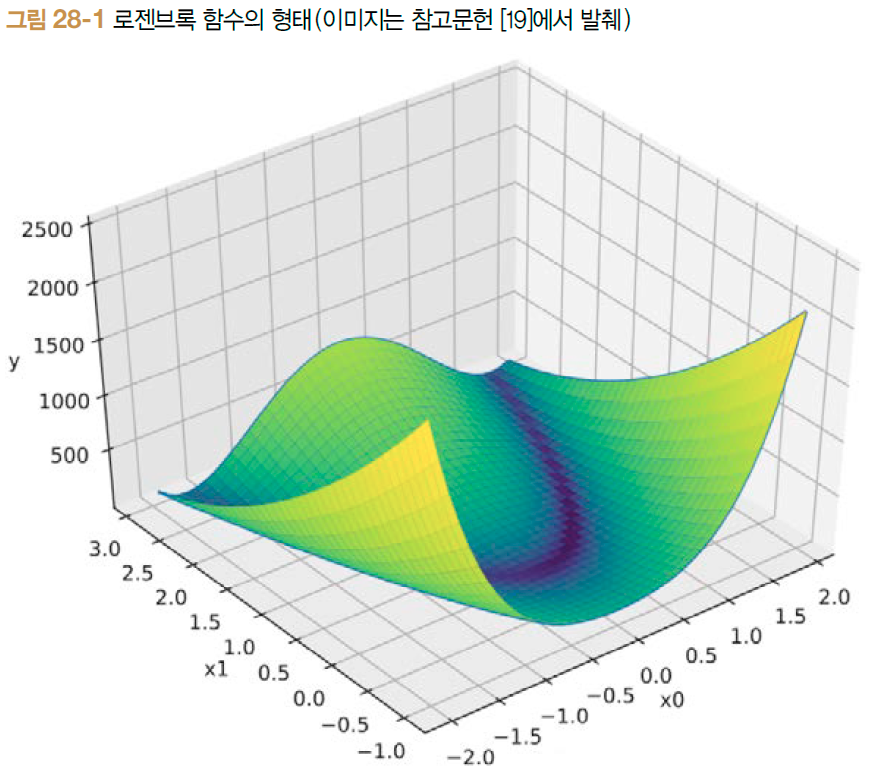

### 미분 계산하기

In [2]:
import numpy as np
#from core_simple import Variable

def rosenbrock(x0, x1):
    y = 100*(x1-x0**2)**2+(1-x0)**2
    return y

In [ ]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print (x0.grad, x1.grad)

### 경사하강법 구현

In [3]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
    print(x0, x1)

    y = rosenbrock(x0, x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

variable(0.0) variable(2.0)


TypeError: unsupported operand type(s) for ** or pow(): 'Variable' and 'int'

file:///home/aiffel/Downloads/%EB%B0%91%EB%B0%94%EB%8B%A53%20%EA%B7%B8%EB%A6%BC%EA%B3%BC%20%EC%88%98%EC%8B%9D/%EA%B7%B8%EB%A6%BC%2028-2.png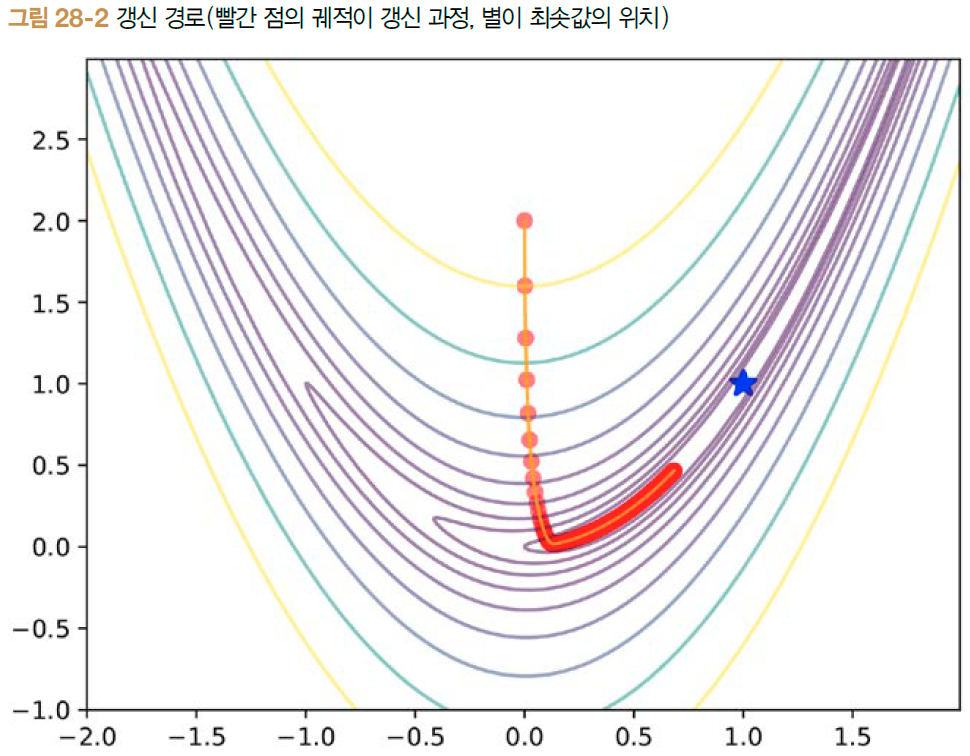

### Step29. 뉴턴 방법으로 푸는 최적화(수동 계산)

### 뉴턴 방법을 활용한 최적화 이론

file:///home/aiffel/Downloads/%EB%B0%91%EB%B0%94%EB%8B%A53%20%EA%B7%B8%EB%A6%BC%EA%B3%BC%20%EC%88%98%EC%8B%9D/%EA%B7%B8%EB%A6%BC%2029-2.png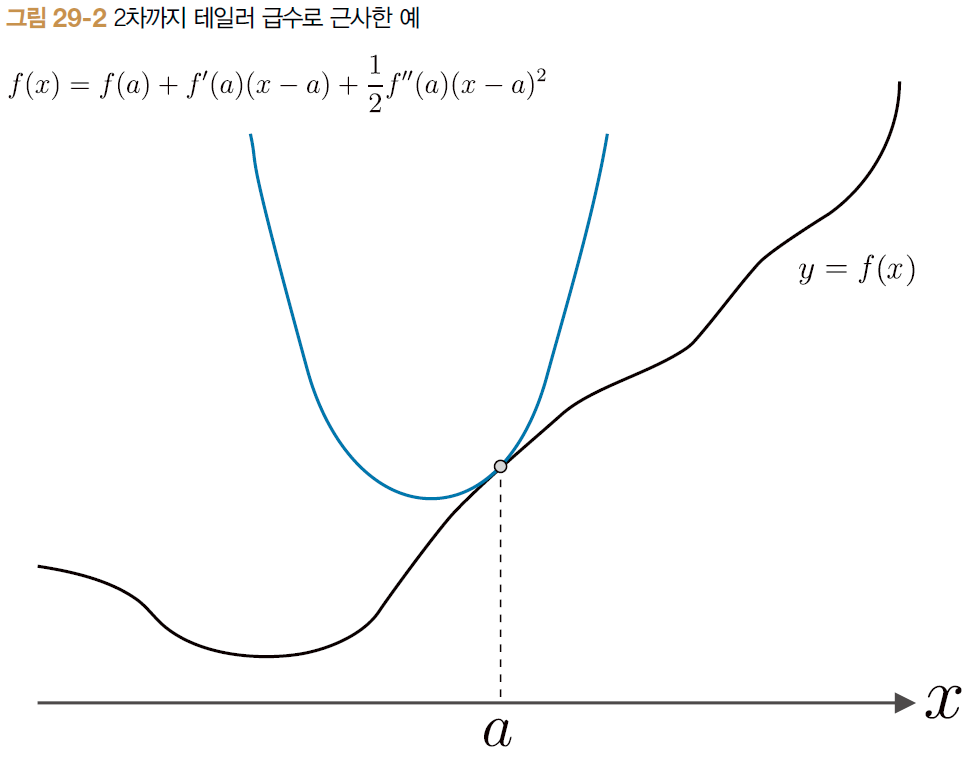

### 뉴턴 방법을 활용한 최적화 구현

In [5]:
def f(x):
    y = x**4-2*x**2
    return y

def gx2(x):
    return 12*x**2-4



In [6]:
x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i , x)
    
    y = f(x)
    x.cleargrad()
    y.backward()
    
    x.data -= x.grad/gx2(x.data)

0 variable(2.0)


TypeError: unsupported operand type(s) for ** or pow(): 'Variable' and 'int'

## Step30. 고차 미분(준비 편)

file:///home/aiffel/Downloads/%EB%B0%91%EB%B0%94%EB%8B%A53%20%EA%B7%B8%EB%A6%BC%EA%B3%BC%20%EC%88%98%EC%8B%9D/%EA%B7%B8%EB%A6%BC%2030-1.png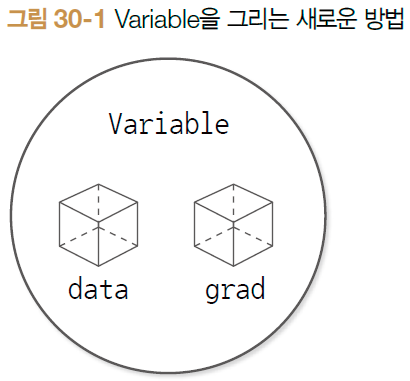

file:///home/aiffel/Downloads/%EB%B0%91%EB%B0%94%EB%8B%A53%20%EA%B7%B8%EB%A6%BC%EA%B3%BC%20%EC%88%98%EC%8B%9D/%EA%B7%B8%EB%A6%BC%2030-2.png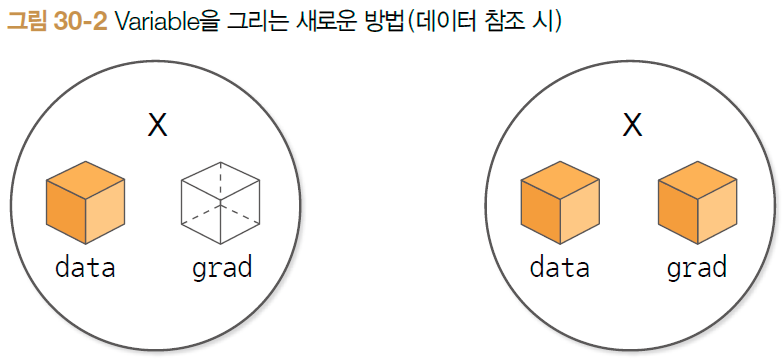

file:///home/aiffel/Downloads/%EB%B0%91%EB%B0%94%EB%8B%A53%20%EA%B7%B8%EB%A6%BC%EA%B3%BC%20%EC%88%98%EC%8B%9D/%EA%B7%B8%EB%A6%BC%2030-3.png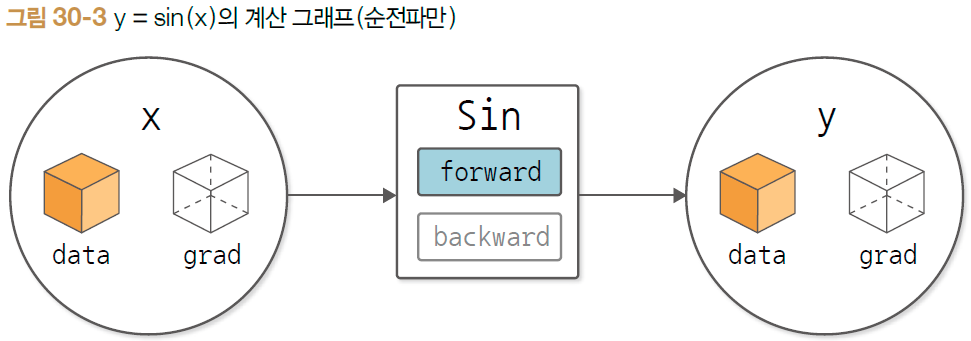

file:///home/aiffel/Downloads/%EB%B0%91%EB%B0%94%EB%8B%A53%20%EA%B7%B8%EB%A6%BC%EA%B3%BC%20%EC%88%98%EC%8B%9D/%EA%B7%B8%EB%A6%BC%2030-4.png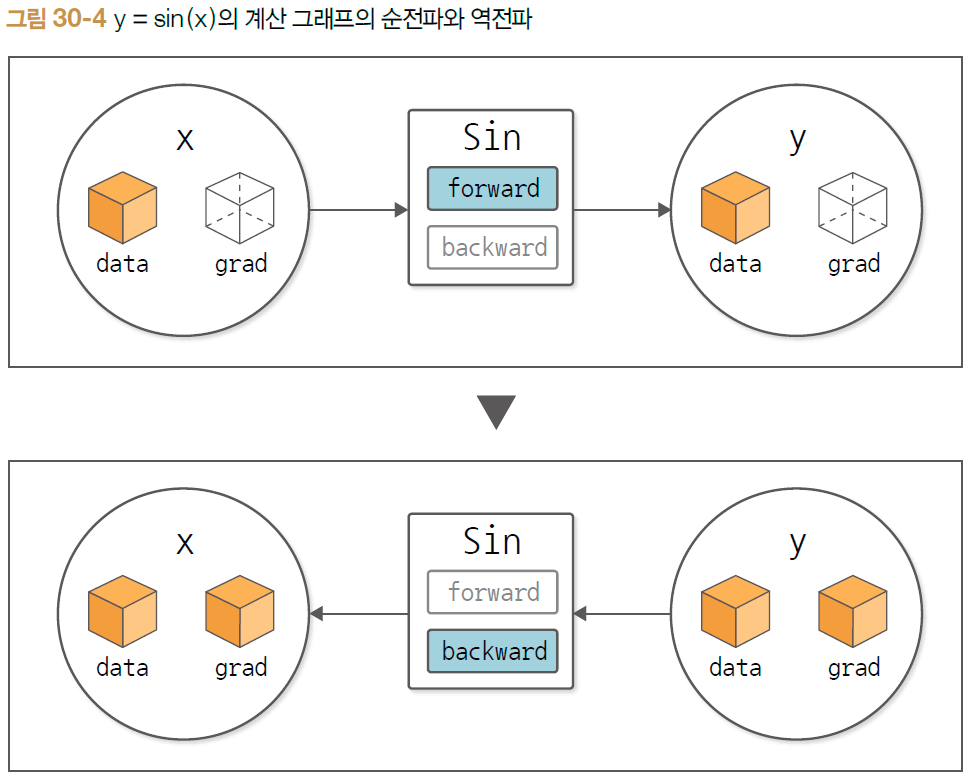